In [46]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier ## model
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np
import seaborn as sns

## load data
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop('id', axis=1)

## split features 
X = df_train.iloc[:, 0:10]
y = df_train.iloc[:, 11]

## train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=102, 
    stratify=y,
)

## pipeline
num_cols = X_train.select_dtypes(exclude=['object']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

num_pipe = Pipeline(
    steps=[('scaler', StandardScaler())
     
    ]
)

cat_pipe = Pipeline(
    steps=[('encoder', OneHotEncoder())
     
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols)
    ]
)

combine_all = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('modelo', AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=102))
    ]
)

combine_all

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'))])),
                ('modelo',
                 AdaBoostClassifier(algorithm='SAMME', n_estimators=100,
                                    random_state=102))])

In [55]:
## Train Score
scores = cross_val_score(
    combine_all,
    X_train,
    y_train, cv=10, scoring='roc_auc', verbose=4
)

print(f'Roc: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

[CV] END ................................ score: (test=0.912) total time=   4.0s
[CV] END ................................ score: (test=0.924) total time=   3.9s
[CV] END ................................ score: (test=0.930) total time=   3.9s
[CV] END ................................ score: (test=0.919) total time=   3.9s
[CV] END ................................ score: (test=0.911) total time=   3.9s
[CV] END ................................ score: (test=0.905) total time=   4.0s
[CV] END ................................ score: (test=0.924) total time=   4.0s
[CV] END ................................ score: (test=0.917) total time=   3.9s
[CV] END ................................ score: (test=0.930) total time=   3.9s
[CV] END ................................ score: (test=0.933) total time=   3.9s
Roc: 0.921 +/- 0.009


In [54]:
## Test Score
scores = cross_val_score(
    combine_all,
    X_test,
    y_test, cv=10, scoring='roc_auc', verbose=4
)

print(f'Roc: {np.mean(scores):.3f} 'f'+/- {np.std(scores):.3f}')

[CV] END ................................ score: (test=0.902) total time=   1.0s
[CV] END ................................ score: (test=0.905) total time=   1.0s
[CV] END ................................ score: (test=0.916) total time=   1.0s
[CV] END ................................ score: (test=0.875) total time=   1.0s
[CV] END ................................ score: (test=0.867) total time=   1.0s
[CV] END ................................ score: (test=0.937) total time=   1.0s
[CV] END ................................ score: (test=0.913) total time=   1.0s
[CV] END ................................ score: (test=0.915) total time=   1.0s
[CV] END ................................ score: (test=0.902) total time=   1.0s
[CV] END ................................ score: (test=0.907) total time=   1.0s
Roc: 0.904 +/- 0.019


## Submit

In [51]:
combine_all.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'))])),
                ('modelo',
                 AdaBoostClassifier(algorithm='SAMME', n_estimators=100,
                                    random_state=102))])

In [61]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv').drop('id', axis=1)
sample = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

sample['loan_status'] = combine_all.predict_proba(df_test)[:, 1]
sample.to_csv('#1.csv', index=False)
sample.head()

,id,loan_status
0,58645,0.560605
1,58646,0.418921
2,58647,0.501545
3,58648,0.437303
4,58649,0.487962


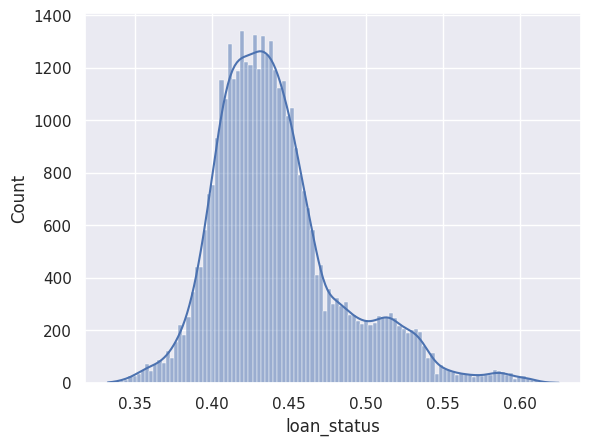

In [68]:
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")
sns.histplot(data=sample, x="loan_status", kde=True);